# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


# Import the FBM healthy eryth

In [3]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/bm_plus_19pcw/data/bm_plus_19pcw_raw_dr_20201007.h5ad')

In [4]:
adata.raw = adata

In [5]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T cell             327
CD8 T cell             171
CD14 monocyte         8763
CD56 bright NK         449
CMP                    425
                      ... 
schwann cells            9
sinusoidal EC          550
stromal macrophage    1464
tDC                    193
tip EC                 362
Length: 64, dtype: int64

In [6]:
celltypes = ['MEMP', 'MEP', 'early erythroid', 'mid erythroid', 'late erythroid']

In [7]:
adata = adata[adata.obs['cell.labels'].isin(celltypes)].copy()

In [8]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
MEMP                  16
MEP                  269
early erythroid     7474
late erythroid      4636
mid erythroid      14297
dtype: int64

In [9]:
cell_numbers = adata.obs.groupby(["fetal.ids"]).apply(len)
cell_numbers

fetal.ids
F21_male_16+2PCW       604
F29_female_17+0PCW    1135
F30_male_14+3PCW       840
F38_male_12PCW         519
F41_female_16PCW      3202
F45_female_13+6PCW     785
F50_female_15PCW      6622
F51_female_15PCW      9442
SB19PCW               3543
dtype: int64

In [10]:
adata = adata[adata.obs['fetal.ids'].isin(["F38_male_12PCW", "F45_female_13+6PCW"])].copy()

In [11]:
adata.obs['cell.labels'] = adata.obs['cell.labels'].replace(["MEP", "MEMP"], ["MEP_MEMP", "MEP_MEMP"])

In [12]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
MEP_MEMP            27
early erythroid    452
late erythroid     186
mid erythroid      639
dtype: int64

In [13]:
cell_numbers = adata.obs.groupby(["fetal.ids"]).apply(len)
cell_numbers

fetal.ids
F38_male_12PCW        519
F45_female_13+6PCW    785
dtype: int64

In [14]:
adata.shape

(1304, 33712)

In [15]:
adata.obs["dataset"] = "fbm"
fbm = adata

In [16]:
fbm.shape

(1304, 33712)

# Import the DS eryth cells

In [17]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/fbm_ds_cite_seq/data/fbm_ds_citeseq_plus_scrna_forMS_20210119.h5ad')

In [18]:
adata.shape

(16743, 33694)

In [19]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CAR                          4
CD8 T cell                 181
CD14 monocyte              320
CD56 bright NK              79
CMP                         50
DC1                         45
DC2                        228
DC3                        108
HSC                        105
ILC precursor               13
MEMP                       130
MK                          83
MOP                        422
MSC                         53
Treg                         8
chondrocyte                  4
early B cell                42
early MK                    34
early erythroid           1348
endothelium                111
eo/baso/mast precursor      53
eosinophil                  63
late erythroid            6336
macrophage                 113
mast cell                   39
mast cell                   27
mature B cell               31
mature NK                  147
mid erythroid             5230
myelocyte                  243
neutrophil                 273
osteoblast                 

In [20]:
adata = adata[adata.obs['cell.labels'].isin(['MEMP', 'early erythroid', 'mid erythroid', 
                                                    'late erythroid'])].copy()

In [21]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
MEMP                130
early erythroid    1348
late erythroid     6336
mid erythroid      5230
dtype: int64

In [22]:
adata.obs["dataset"] = "ds_fbm"
ds_fbm = adata

In [23]:
ds_fbm.shape

(13044, 33694)

# Combine the datasets

In [24]:
from scipy import sparse

objects = [ds_fbm, fbm]

for i in objects:
    array_vals = i.X
    i.X = sparse.csr_matrix(i.X)
    i.raw = i
    i.X = array_vals

In [25]:
# make DS gene data categorical, so merging can go ahead

ds_fbm.var = ds_fbm.var.astype("category")

In [26]:
ds_fbm.var.dtypes

gene_ids-0            category
gene_ids-1            category
highly_variable-1     category
means-1               category
dispersions-1         category
dispersions_norm-1    category
dtype: object

In [27]:
fbm.var.dtypes

gene_ids-1         category
feature_types-1    category
dtype: object

In [28]:
merged = fbm.concatenate(ds_fbm, index_unique=None, join='inner')

In [29]:
merged.shape

(14348, 33694)

In [30]:
cell_numbers = merged.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
MEMP                130
MEP_MEMP             27
early erythroid    1800
late erythroid     6522
mid erythroid      5869
dtype: int64

In [31]:
merged.obs["dataset_cell.labels"] = merged.obs["dataset"].astype(str) + '_' + merged.obs["cell.labels"].astype(str)

In [32]:
cell_numbers = merged.obs.groupby(["dataset_cell.labels"]).apply(len)
cell_numbers

dataset_cell.labels
ds_fbm_MEMP                130
ds_fbm_early erythroid    1348
ds_fbm_late erythroid     6336
ds_fbm_mid erythroid      5230
fbm_MEP_MEMP                27
fbm_early erythroid        452
fbm_late erythroid         186
fbm_mid erythroid          639
dtype: int64

# Pre-process the data

In [33]:
adata=merged

In [34]:
# normalise count data 
sc.pp.normalize_total(adata)

In [35]:
# log the count data 
sc.pp.log1p(adata)

In [36]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [37]:
# scale the data 
sc.pp.scale(adata, max_value=10)
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

# Import cell cycling genes

In [38]:
#Score cell cycle and visualize the effect:
# load file in
cc_genes_file = '/Users/b8058304/Documents/PhD_work/Coding/bm/resources_for_pipelines/cell_cycle_makosco.csv'
cc_genes = pd.read_csv(cc_genes_file, delimiter=',')
# removing na from s and g2m list
s_genes = cc_genes['S'].dropna()
g2m_genes = cc_genes['G2/M'].dropna()

In [39]:
y_genes = s_genes.tolist()
no_trail = []

for x in y_genes:
    y = x.strip()
    no_trail.append(y)
    
s_genes = no_trail 

In [40]:
y_genes = g2m_genes.tolist()
no_trail = []

for x in y_genes:
    y = x.strip()
    no_trail.append(y)
    
g2m_genes = no_trail 

In [41]:
s_genes_mm = adata.var_names[np.isin(adata.var_names, s_genes)]

In [42]:
g2m_genes_mm = adata.var_names[np.isin(adata.var_names, g2m_genes)]

In [43]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes_mm, g2m_genes=g2m_genes_mm)

In [44]:
adata.obs["phase_combined"] = adata.obs["phase"].replace(["G2M", "S"], ["G2M/S", "G2M/S"])

In [45]:
adata.obs["S/G2M_score_combined"] = (adata.obs["G2M_score"] + adata.obs["S_score"])/2

# Reorder the celltype/tissue metadata col (in prep for heatmap)

In [46]:
# order tissue_cell.labels column

adata.obs["dataset_cell.labels"].unique()

array(['fbm_early erythroid', 'fbm_mid erythroid', 'fbm_late erythroid',
       'fbm_MEP_MEMP', 'ds_fbm_early erythroid', 'ds_fbm_late erythroid',
       'ds_fbm_mid erythroid', 'ds_fbm_MEMP'], dtype=object)

In [47]:
# order tissue_cell.labels column

adata.obs["dataset_cell.labels"] = adata.obs["dataset_cell.labels"].astype("category")

adata.obs["dataset_cell.labels"] = adata.obs["dataset_cell.labels"].cat.reorder_categories(['ds_fbm_MEMP',
         'ds_fbm_early erythroid', 'ds_fbm_mid erythroid', 'ds_fbm_late erythroid',
         'fbm_MEP_MEMP', 'fbm_early erythroid', 'fbm_mid erythroid', 'fbm_late erythroid'])

In [48]:
adata.obs["dataset_cell.labels"].unique()

[fbm_early erythroid, fbm_mid erythroid, fbm_late erythroid, fbm_MEP_MEMP, ds_fbm_early erythroid, ds_fbm_late erythroid, ds_fbm_mid erythroid, ds_fbm_MEMP]
Categories (8, object): [fbm_early erythroid, fbm_mid erythroid, fbm_late erythroid, fbm_MEP_MEMP, ds_fbm_early erythroid, ds_fbm_late erythroid, ds_fbm_mid erythroid, ds_fbm_MEMP]

In [49]:
# save cell cycle scores within metadata as a dataframe (called enrichement scores)
adata.obs["labels"] = adata.obs["dataset_cell.labels"]
meta = pd.DataFrame(adata.obs)
enrichment_scores_df = meta[meta.columns[-2:]]
enrichment_scores_df

,S/G2M_score_combined,labels
F38_boneMarrow_CD45-_FCAImmP7528282_3prime_AAACCTGAGATTACCC,0.013212,fbm_early erythroid
F38_boneMarrow_CD45-_FCAImmP7528282_3prime_AAAGATGTCATCTGTT,-0.021764,fbm_early erythroid
F38_boneMarrow_CD45-_FCAImmP7528282_3prime_AACGTTGCAGGACCCT,-0.046263,fbm_mid erythroid
F38_boneMarrow_CD45-_FCAImmP7528282_3prime_AACGTTGCAGTCAGCC,-0.019620,fbm_mid erythroid
F38_boneMarrow_CD45-_FCAImmP7528282_3prime_AAGGCAGGTTGTGGCC,0.020690,fbm_early erythroid
...,...,...
TTTGTCAAGTTCGCGC-1-DSOX19,0.065743,ds_fbm_late erythroid
TTTGTCAGTATTAGCC-1-DSOX19,-0.009848,ds_fbm_late erythroid
TTTGTCAGTGCACTTA-1-DSOX19,0.381640,ds_fbm_mid erythroid
TTTGTCATCAAGGCTT-1-DSOX19,0.075645,ds_fbm_late erythroid


In [50]:
# calculate mean enrichment scores by celltype
mean_enrichment_scores_df = enrichment_scores_df.groupby('labels').mean()
mean_enrichment_scores_df = mean_enrichment_scores_df.T
mean_enrichment_scores_df = mean_enrichment_scores_df.sort_index()
mean_enrichment_scores_df

labels,ds_fbm_MEMP,ds_fbm_early erythroid,ds_fbm_mid erythroid,ds_fbm_late erythroid,fbm_MEP_MEMP,fbm_early erythroid,fbm_mid erythroid,fbm_late erythroid
S/G2M_score_combined,-0.040691,0.126396,0.250626,0.003421,-0.093815,0.005963,0.032413,-0.007926


# Run heatmap

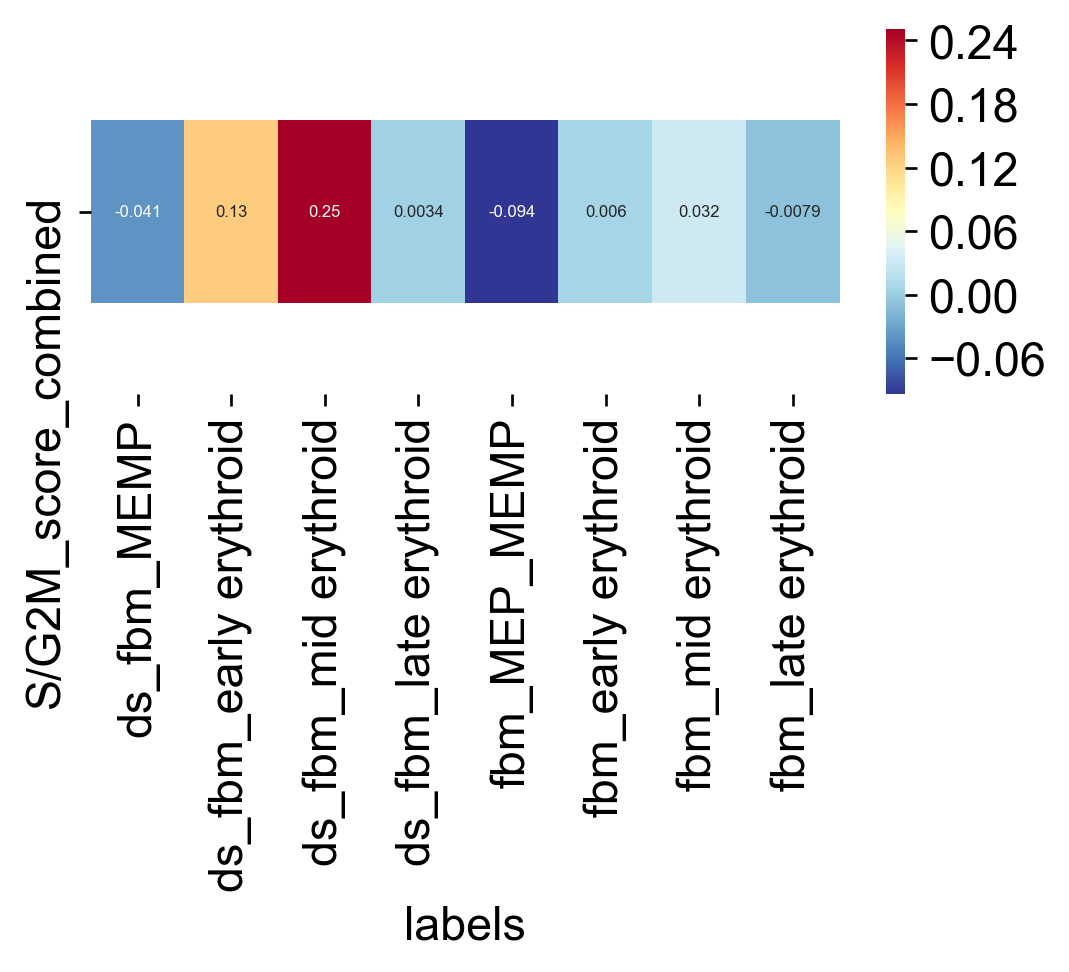

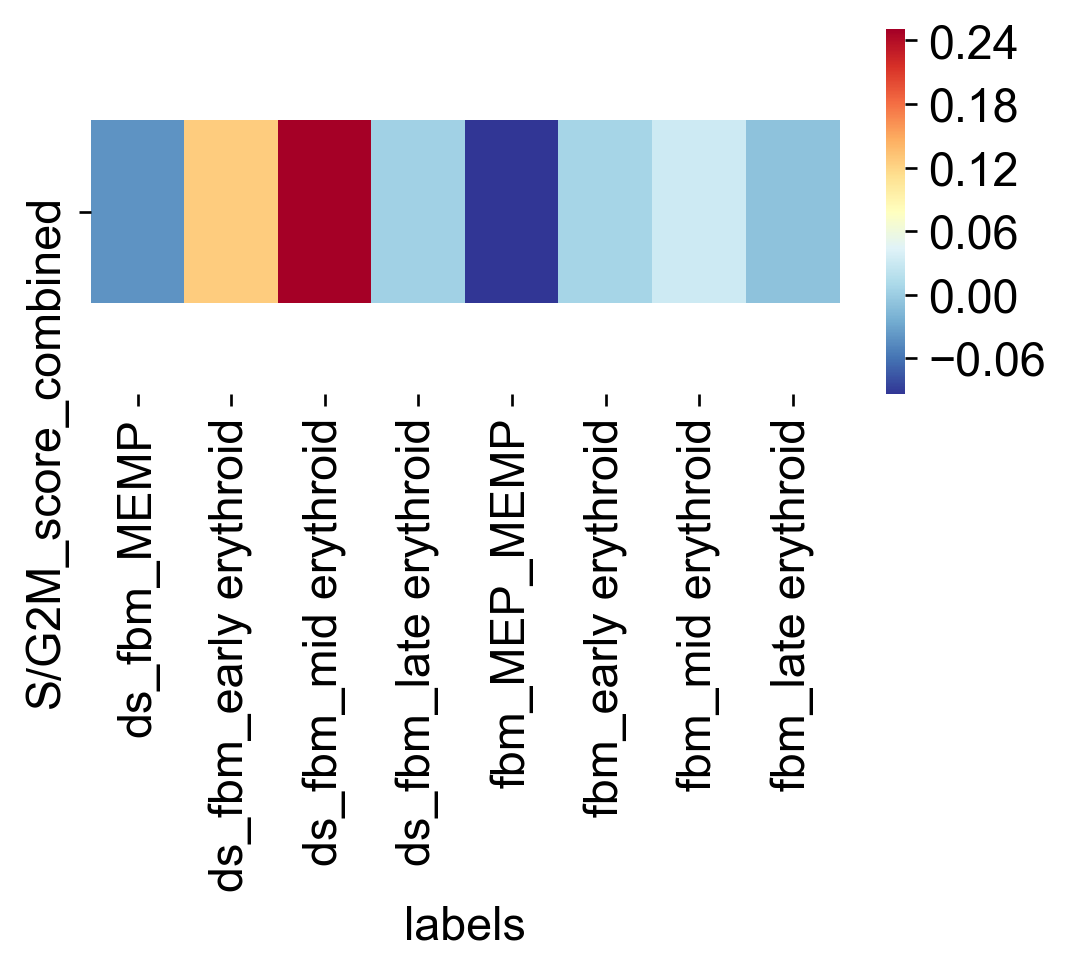

In [51]:
plt.figure(figsize=(5, 2))
fig = sns.heatmap(mean_enrichment_scores_df, annot=True, fmt=".2", annot_kws={"size": 5}, cmap="RdYlBu_r").get_figure() #xticklabels=cell_label_order, yticklabels=cell_label_order,
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
fig.savefig("figures/figs5b_no-ds_ds_eryth_cycle_comparison_numbers_yes_20210125.pdf")

plt.figure(figsize=(5, 2))
fig = sns.heatmap(mean_enrichment_scores_df, cmap="RdYlBu_r").get_figure() 
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
fig.savefig("figures/figs5b_no-ds_ds_eryth_cycle_comparison_numbers_no_20210125.pdf")

# Save the data

In [52]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [53]:
adata.X

<14348x33694 sparse matrix of type '<class 'numpy.float32'>'
	with 18556006 stored elements in Compressed Sparse Row format>

In [54]:
adata.raw.X

<14348x33694 sparse matrix of type '<class 'numpy.float32'>'
	with 21118281 stored elements in Compressed Sparse Row format>

In [55]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/data/figs5b_no-ds_ds_eryth_cycle_20210125.h5ad")

... storing '__is_in_cluster__' as categorical
... storing 'age' as categorical
... storing 'april_cell.labels' as categorical
... storing 'auto_prd' as categorical
... storing 'cell.labels' as categorical
... storing 'cell.labels_20200708' as categorical
... storing 'cell.labels_20200713' as categorical
... storing 'cell.labels_20200718' as categorical
... storing 'dataset' as categorical
... storing 'doublets' as categorical
... storing 'fetal.ids' as categorical
... storing 'gender' as categorical
... storing 'is_doublet' as categorical
... storing 'is_doublet_poptrim' as categorical
... storing 'is_doublet_wolock' as categorical
... storing 'lanes' as categorical
... storing 'leiden' as categorical
... storing 'lr_pred' as categorical
... storing 'mad_prd' as categorical
... storing 'mito.threshold' as categorical
... storing 'nk_meta' as categorical
... storing 'orig.ident' as categorical
... storing 'processing.type' as categorical
... storing 'sequencing.type' as categorical
...